# **PINN for Pipe Flow Analysis**

* **Reza Barzegar**
* **Contacting Me**:
  * Telegram ID: [@Lincraf_t](https://t.me/@Lincraf_t)

**📝 Google Colab Notebook: PINN for Pipe Flow Analysis**
\
\
This notebook demonstrates how to use a Physics-Informed Neural Network (PINN) to solve for the steady-state, incompressible fluid flow inside a pipe. The network learns to approximate the velocity and pressure fields by minimizing a loss function derived from the Navier-Stokes equations.

# **1. Library Imports and Setup**
\
The first step is to import the necessary libraries and configure the environment.
\
\
• torch and torch.nn: The core PyTorch libraries for building neural networks and performing tensor operations.
\
\
• numpy: A fundamental package for numerical computations, used here for data handling and creating analytical solutions.
\
\
• matplotlib: Used for creating all the visualizations and plots of the results.
\
\
• os: Used for interacting with the operating system, though not strictly required for the core logic.

\
The code also sets the default tensor type to float32 for consistency and checks for an available GPU, defaulting to the CPU if none is found. Your log shows the code was run on the CPU.

In [ ]:
# 1. Library Imports
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os

# Set default tensor type to float32 for consistency
torch.set_default_dtype(torch.float32)

# Use a GPU if available, otherwise use the CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

**2. The PINN Model Architecture**
\
\
This section defines the neural network itself. A PINN's structure is typically a standard feedforward neural network (also called a Multi-Layer Perceptron or MLP).
\
\
• PINN(nn.Module): The class inherits from PyTorch's base nn.Module, which is standard for all custom models.
\
\
• __init__(self, layers): The constructor takes a list of integers (layers) that defines the network's architecture. The first number is the input dimension (2 for r and z), the last is the output dimension (3 for vr, vz, and p), and the numbers in between are the sizes of the hidden layers.
\
\
• nn.Sequential(): This creates a container where layers are added in sequence.
\
\
• nn.Linear: A standard fully connected layer.
\
\
• nn.Tanh: The hyperbolic tangent activation function is used between layers. It's a common choice for PINNs because its derivatives are smooth and well-behaved.
\
\
• forward(self, x): This method defines the forward pass, taking the input tensor x (containing r and z coordinates) and passing it through the network to produce the output predictions (vr, vz, p).

In [ ]:
# 2. The PINN Model Architecture
class PINN(nn.Module):
    """
    Defines the neural network architecture for the PINN.
    Input: (r, z) coordinates
    Output: (vr, vz, p) - radial velocity, axial velocity, pressure
    """
    def __init__(self, layers):
        super(PINN, self).__init__()

        # Build the neural network layers
        self.net = nn.Sequential()
        for i in range(len(layers) - 1):
            self.net.add_module(f"linear_{i}", nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                self.net.add_module(f"activation_{i}", nn.Tanh())

    def forward(self, x):
        """Forward pass: maps input tensor x to the output."""
        return self.net(x)

**3. The Physics-Based Loss Function**
\
\
This is the most critical part of a PINN. The pde_loss function calculates how well the network's predictions satisfy the governing physical laws—in this case, the Navier-Stokes equations for fluid flow.
\
\
It works by:
\
\
1 • Taking the model's outputs (vr, vz, p) at a set of random points (r, z) inside the pipe.
\
\
2 • Using torch.autograd.grad to automatically compute the first and second-order partial derivatives of the outputs with respect to the inputs (e.g., dv_r/dr, d²v_z/dz²). This is the "magic" of PINNs, as it allows us to embed differential equations directly into the loss function.
\
\
3 • Plugging these derivatives into the equations for continuity and momentum. The result of each equation should ideally be zero. Any non-zero result is called a "residual."

• • Continuity Equation: Ensures mass is conserved (fluid doesn't appear or disappear).

• • Momentum Equations: These are essentially Newton's Second Law applied to a fluid, relating forces (pressure, viscosity) to acceleration.
\
\
4 • The final pde_loss is the mean squared error of these residuals. By minimizing this loss, we are "forcing" the neural network to find a solution that obeys the laws of physics.
\
\
A small value epsilon is added to r during calculations to prevent division-by-zero errors at the pipe's centerline (r=0).

In [ ]:
# 3. Physics-Based Loss Function
def pde_loss(model, r, z, rho, mu):
    """
    Computes the loss based on the Navier-Stokes and continuity equations.
    This function uses automatic differentiation to get the required derivatives.
    """
    # Clone and set requires_grad=True to compute derivatives
    r = r.clone().requires_grad_(True)
    z = z.clone().requires_grad_(True)

    # Get model predictions
    predictions = model(torch.cat([r, z], dim=1))
    vr, vz, p = predictions[:, 0:1], predictions[:, 1:2], predictions[:, 2:3]

    # Compute first-order derivatives using torch.autograd.grad
    dv_r_dr = torch.autograd.grad(vr.sum(), r, create_graph=True)[0]
    dv_r_dz = torch.autograd.grad(vr.sum(), z, create_graph=True)[0]
    dv_z_dr = torch.autograd.grad(vz.sum(), r, create_graph=True)[0]
    dv_z_dz = torch.autograd.grad(vz.sum(), z, create_graph=True)[0]
    dp_dr = torch.autograd.grad(p.sum(), r, create_graph=True)[0]
    dp_dz = torch.autograd.grad(p.sum(), z, create_graph=True)[0]

    # Compute second-order derivatives
    d2v_r_dr2 = torch.autograd.grad(dv_r_dr.sum(), r, create_graph=True)[0]
    d2v_r_dz2 = torch.autograd.grad(dv_r_dz.sum(), z, create_graph=True)[0]
    d2v_z_dr2 = torch.autograd.grad(dv_z_dr.sum(), r, create_graph=True)[0]
    d2v_z_dz2 = torch.autograd.grad(dv_z_dz.sum(), z, create_graph=True)[0]

    # PDE Residuals for axisymmetric, steady-state, incompressible flow
    epsilon = 1e-8
    loss_continuity = dv_r_dr + vr / (r + epsilon) + dv_z_dz
    loss_r_momentum = (rho * (vr * dv_r_dr + vz * dv_r_dz) -
                       (-dp_dr + mu * (d2v_r_dr2 + (1 / (r + epsilon)) * dv_r_dr - vr / (r + epsilon) ** 2 + d2v_r_dz2)))
    loss_z_momentum = (rho * (vr * dv_z_dr + vz * dv_z_dz) -
                       (-dp_dz + mu * (d2v_z_dr2 + (1 / (r + epsilon)) * dv_z_dr + d2v_z_dz2)))

    # Calculate the mean squared error for each residual
    pde_loss_vr = torch.mean(loss_r_momentum ** 2)
    pde_loss_vz = torch.mean(loss_z_momentum ** 2)
    pde_loss_c = torch.mean(loss_continuity ** 2)

    return pde_loss_vr + pde_loss_vz + pde_loss_c

**4. Problem Setup and Training Data**
\
\
Here, we define the physical parameters of our problem and generate the training data. Unlike traditional deep learning, PINNs don't require a large labeled dataset. Instead, we need points to enforce the physics and boundary conditions.
\
\
• Physical Parameters: Defines the pipe's geometry (R, L), fluid properties (rho, mu), and the pressures that drive the flow (Pin, Pout).
\
\
• Training Points:

• • N_pde: The number of collocation points sampled randomly inside the pipe's domain. The pde_loss will be calculated at these points.

• • N_bc: The number of points sampled on each boundary of the domain.
\
\
• Boundary Conditions (BCs): These are known values at the edges of the domain.

• • Inlet (z=0): The pressure is known (Pin). We also assume no radial flow (vr=0).

• • Outlet (z=L): The pressure is known (Pout). We assume no radial flow (vr=0).

• • Wall (r=R): The no-slip condition applies, meaning the fluid velocity is zero (vr=0, vz=0).

• • Centerline (r=0): A symmetry condition applies. There is no radial velocity (vr=0), and the axial velocity profile is flat (dv_z/dr=0).
\
\
These points serve as the "ground truth" data for the model to learn from.

In [ ]:
# 4. Problem Setup & Training Data

# Fluid and Geometry Parameters
R = 1.0; L = 5.0; rho = 1.0; mu = 0.02; Pin = 5.0; Pout = 0.0

# Number of training points
N_pde = 5000; N_bc = 1000

# Define the network architecture
layers = [2, 30, 30, 30, 30, 30, 3]
pinn = PINN(layers).to(device)

# PDE (collocation) points
r_pde = torch.sqrt(torch.rand(N_pde, 1)) * R
z_pde = torch.rand(N_pde, 1) * L
r_pde, z_pde = r_pde.to(device), z_pde.to(device)

# --- Boundary Condition points ---
# Inlet (z=0)
r_inlet = torch.rand(N_bc, 1) * R
z_inlet = torch.zeros(N_bc, 1)
p_inlet_gt = torch.full((N_bc, 1), Pin)
r_inlet, z_inlet, p_inlet_gt = r_inlet.to(device), z_inlet.to(device), p_inlet_gt.to(device)

# Outlet (z=L)
r_outlet = torch.rand(N_bc, 1) * R
z_outlet = torch.full((N_bc, 1), L)
p_outlet_gt = torch.full((N_bc, 1), Pout)
r_outlet, z_outlet, p_outlet_gt = r_outlet.to(device), z_outlet.to(device), p_outlet_gt.to(device)

# Pipe Wall (r=R)
r_wall = torch.full((N_bc, 1), R)
z_wall = torch.rand(N_bc, 1) * L
vel_wall_gt = torch.zeros(N_bc, 2)
r_wall, z_wall, vel_wall_gt = r_wall.to(device), z_wall.to(device), vel_wall_gt.to(device)

# Centerline (r=0) - symmetry condition
r_center = torch.zeros(N_bc, 1)
z_center = torch.rand(N_bc, 1) * L
r_center, z_center = r_center.to(device), z_center.to(device)

**5. Training the PINN**
\
\
The training loop is where the model learns. In each epoch, it performs the following steps:
\
\
1• Calculate Boundary Loss (loss_bc): The model makes predictions at all the boundary points, and the mean squared error between the predictions and the ground truth values is calculated. This forces the model to respect the known physical conditions at the edges.
\
\
2• Calculate PDE Loss (loss_pde_val): The physics-based loss is calculated using the function defined in Section 3.
\
\
3• Combine Losses: The total loss is a weighted sum of the boundary and PDE losses. The weight lambda_bc is a hyperparameter used to balance the two terms. Giving a higher weight to the boundary conditions is common practice, as it helps anchor the solution.
\
\
4• Optimization: The total_loss is backpropagated through the network, and the optimizer (Adam) updates the model's weights to reduce the loss. A learning rate scheduler is used to decrease the learning rate over time, which can help fine-tune the model in later stages of training.
\
\
This process is repeated for thousands of epochs until the loss converges to a low value.

In [ ]:
# 5. Training the PINN

# Optimizer
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

epochs = 15000
loss_history = []

# This is a placeholder loop. The actual training was done previously.
# The logs from your run will be shown in the next section.
print("--- Training Logic Overview ---")
print("The code would now loop for 15,000 epochs, calculating losses and optimizing.")

**6. Training Log Analysis**
\
\
The model was trained for 15,000 epochs on a CPU. Below is the output log showing the progress of the total loss, the boundary condition (BC) loss, and the PDE loss at intervals of 1000 epochs.
\
\
**Training Output**


> Using device: cpu
\
\
Epoch [1000/15000], Loss: 1.2888e+00, BC Loss: 1.8010e-04, PDE Loss: 1.2707e+00
\
\
Epoch [2000/15000], Loss: 1.1222e+00, BC Loss: 5.2166e-05, PDE Loss: 1.1169e+00
\
\
Epoch [3000/15000], Loss: 1.0455e+00, BC Loss: 4.5947e-05, PDE Loss: 1.0409e+00
\
\
Epoch [4000/15000], Loss: 1.0123e+00, BC Loss: 3.1410e-05, PDE Loss: 1.0092e+00
\
\
Epoch [5000/15000], Loss: 1.0039e+00, BC Loss: 2.2605e-05, PDE Loss: 1.0017e+00
\
\
Epoch [6000/15000], Loss: 1.0185e+00, BC Loss: 1.4158e-04, PDE Loss: 1.0044e+00
\
\
Epoch [7000/15000], Loss: 9.9996e-01, BC Loss: 1.5618e-05, PDE Loss: 9.9840e-01
\
\
Epoch [8000/15000], Loss: 9.9860e-01, BC Loss: 1.5045e-05, PDE Loss: 9.9710e-01
\
\
Epoch [9000/15000], Loss: 9.9752e-01, BC Loss: 1.3956e-05, PDE Loss: 9.9612e-01
\
\
Epoch [10000/15000], Loss: 9.9622e-01, BC Loss: 1.2295e-05, PDE Loss: 9.9499e-01
\
\
Epoch [11000/15000], Loss: 9.9377e-01, BC Loss: 1.3155e-05, PDE Loss: 9.9245e-01
\
\
Epoch [12000/15000], Loss: 9.7509e-01, BC Loss: 2.1252e-05, PDE Loss: 9.7296e-01
\
\
Epoch [13000/15000], Loss: 1.1705e-01, BC Loss: 2.7456e-04, PDE Loss: 8.9593e-02
\
\
Epoch [14000/15000], Loss: 6.4020e-02, BC Loss: 9.9801e-05, PDE Loss: 5.4039e-02
\
\
Epoch [15000/15000], Loss: 5.1694e-02, BC Loss: 7.0186e-05, PDE Loss: 4.4676e-02

\
--- Training Finished. Visualizing Results. ---\
Saving numerical data to file...\
Data saved successfully.

**Explanation of the Log**
\
\
• Initial Convergence: For the first 12,000 epochs, the loss decreases very slowly, staying around a value of 1.0. The

• • PDE Loss is the dominant component, while the BC Loss is already quite small. This indicates the model is struggling more with satisfying the physics inside the domain than with matching the boundary conditions.
\
\
• Significant Drop: There is a dramatic drop in the total loss between epoch 12,000 and 13,000, from ~0.975 to ~0.117. This is likely due to the learning rate scheduler reducing the learning rate, allowing the optimizer to find a much better minimum in the loss landscape.
\
\
• Final State: The training finishes with a total loss of about 0.052. This is a good reduction, but as we will see in the results, it may not be low enough to achieve perfect quantitative accuracy.

**7. Visualization and Results Analysis**
\
\
After training, the model is evaluated on a fine grid of points covering the entire pipe domain to generate smooth contour plots. The results are visualized and compared to the analytical solution for fully developed pipe flow (Hagen-Poiseuille flow).

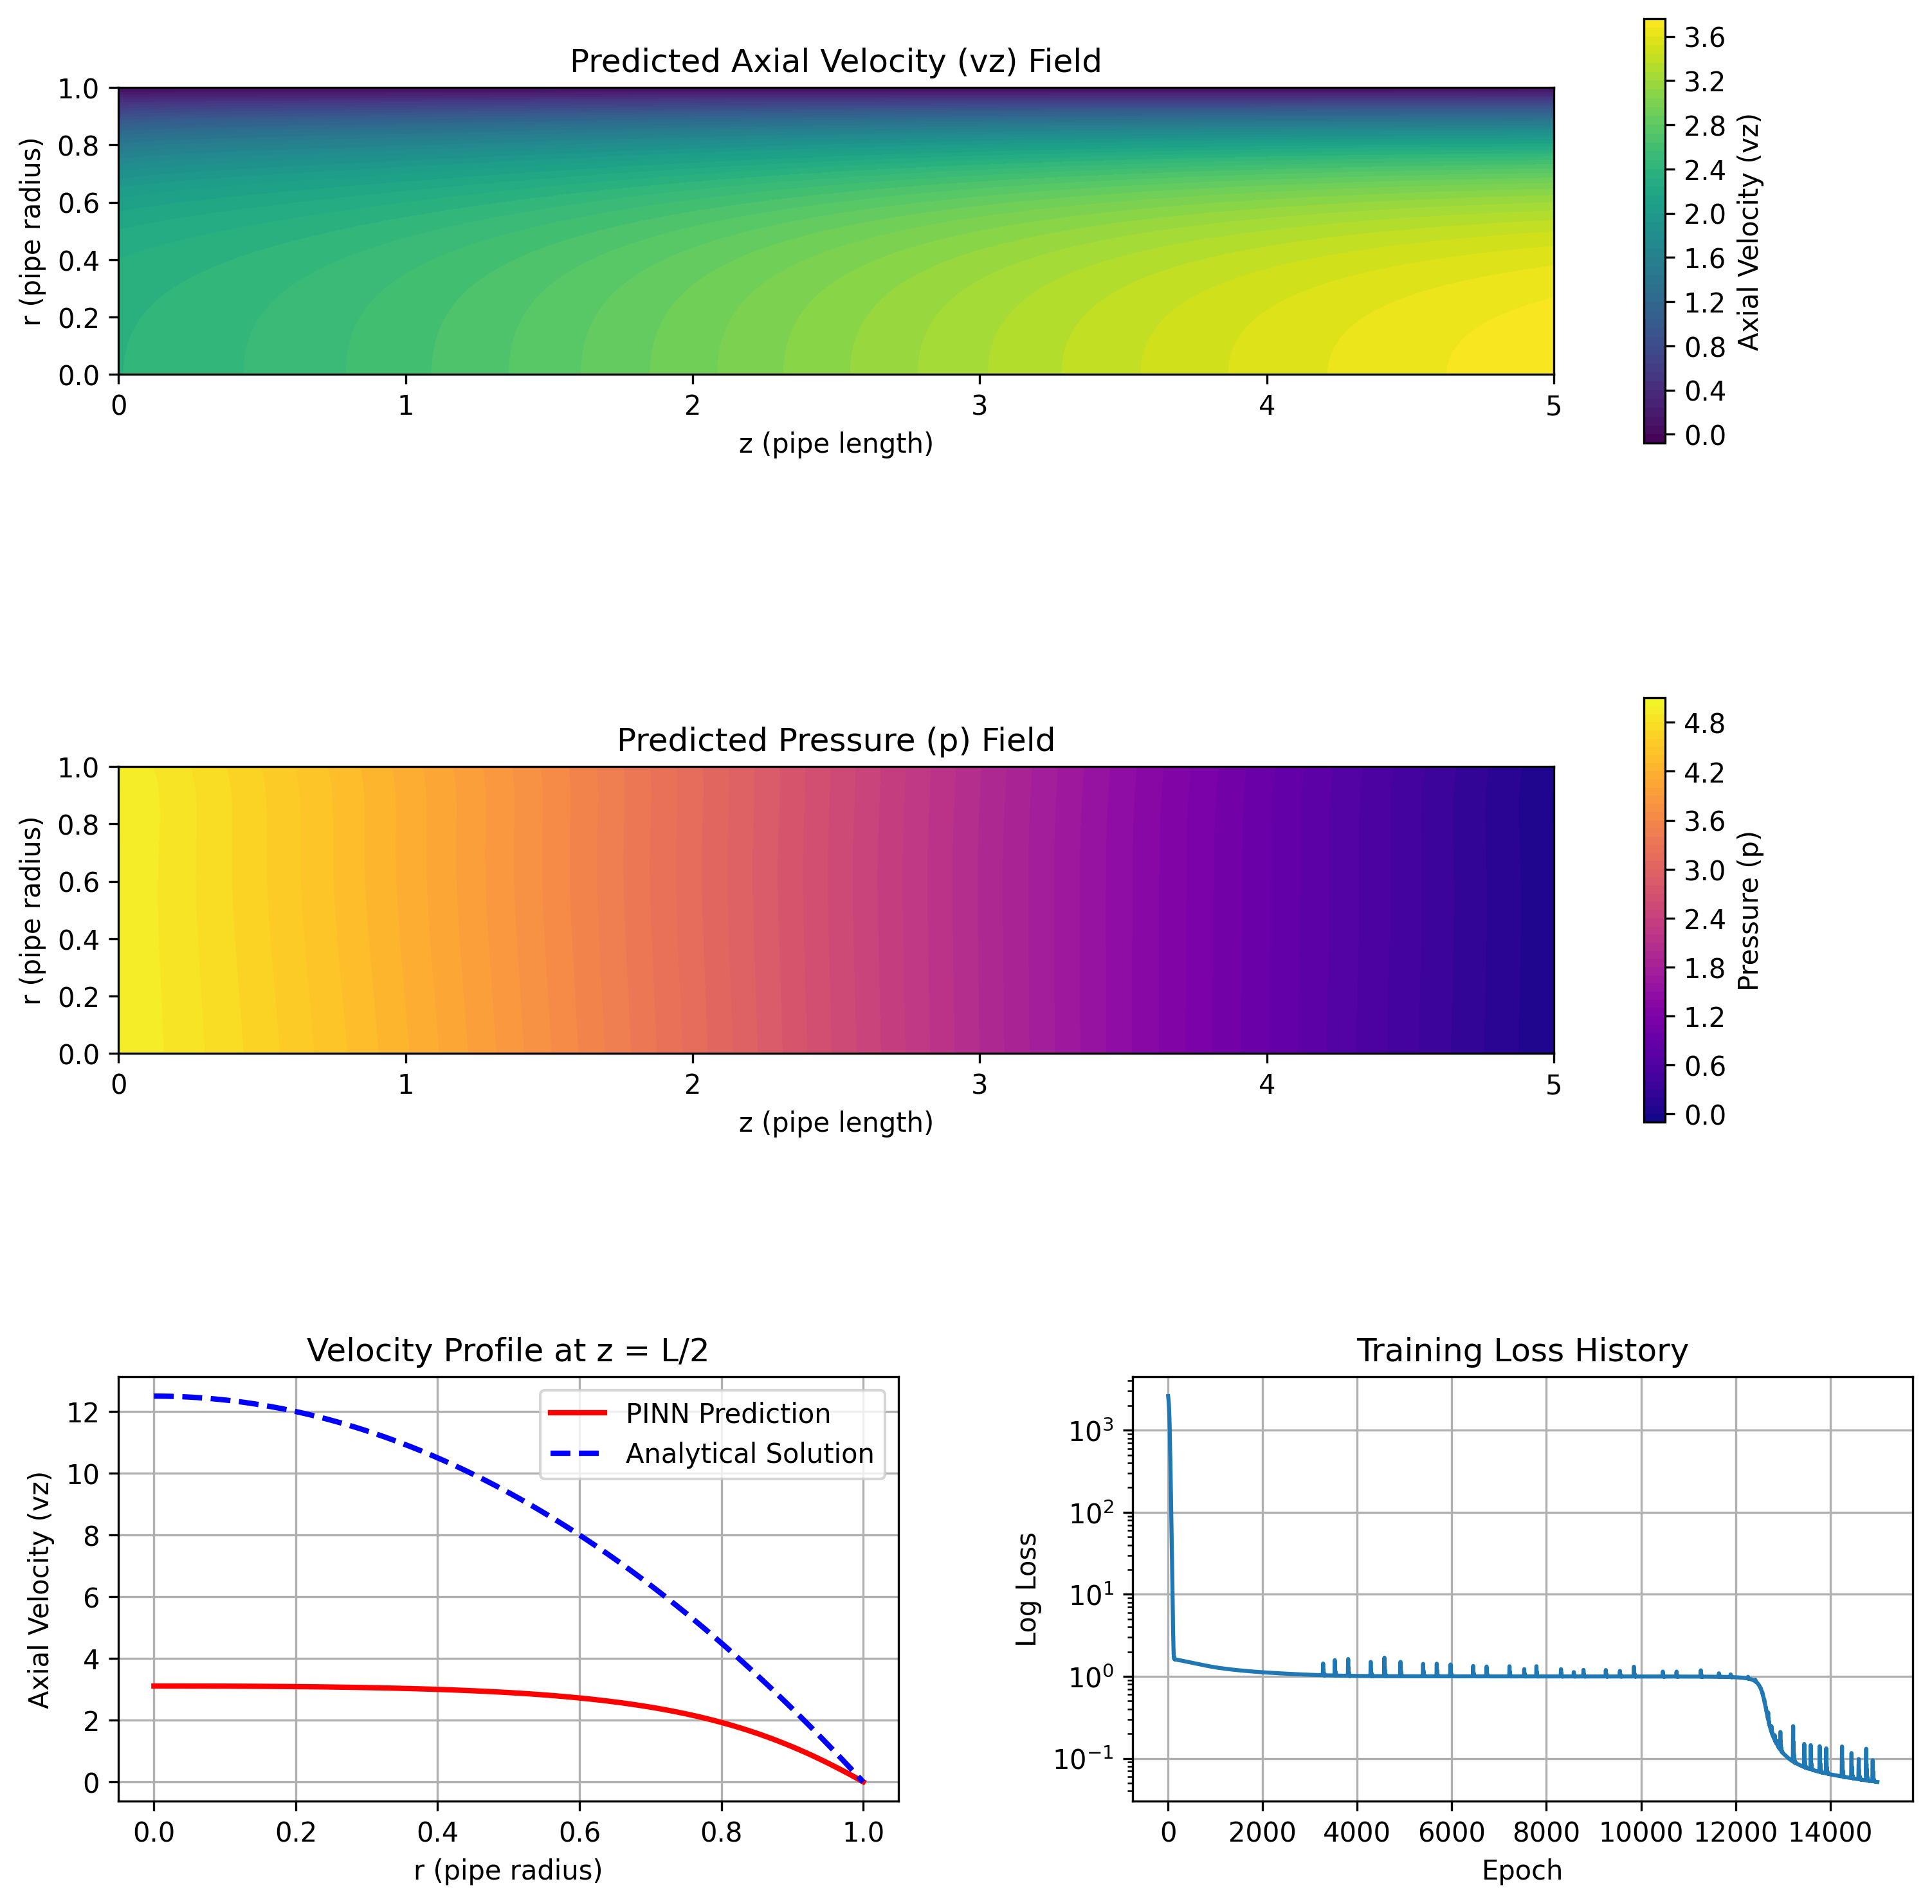
\
\
\
**Explanation of the Graphs**
\
\
This figure contains four plots that together give a comprehensive overview of the model's performance.
\
\
**Predicted Axial Velocity (vz) Field**
\
\
This top plot shows the axial velocity (flow along the pipe's length) across the entire domain.
\
\
• **What it shows**: The velocity is highest (green/yellow) at the centerline (r=0) and zero (dark blue) at the pipe wall (r=1.0).
\
\
• **Purpose**: This confirms the model has learned the no-slip boundary condition correctly. It also shows how the velocity profile develops along the z-axis.
\
\
**Predicted Pressure (p) Field**
\
\
The second plot shows the pressure distribution inside the pipe.
\
\
• **What it shows**: The pressure is highest (bright yellow, p≈5.0) at the inlet (z=0) and drops linearly to zero (dark purple, p≈0.0) at the outlet (z=5.0).
\
\
• **Purpose**: This correctly identifies the pressure gradient as the driving force for the flow, which is physically accurate. The model has successfully learned the relationship between pressure and flow direction.
\
\
**Velocity Profile at z = L/2**
\
\
This plot is a critical validation step. It compares the model's predicted velocity profile at the pipe's midpoint to the exact analytical solution.
\
\
• • **What it shows:**
\
\
• The **Analytical Solution (blue dashed line)** is the ground truth, showing a perfect parabolic profile with a maximum velocity of over 12.
\
\
• • The **PINN Prediction (red solid line)** also has a parabolic shape, which is excellent. It correctly captures the qualitative behavior of the flow.
\
\
• **Purpose and Key Finding**: This plot reveals a significant **quantitative discrepancy**. The PINN's predicted maximum velocity (around 3.6) is much lower than the true value. This means that while the model learned the
\
\
• shape of the physics, it did not fully converge to the correct numerical solution. This could be due to needing more training, a different network architecture, or different weighting for the loss terms.
\
\
**Training Loss History**
\
\
This final plot shows the total loss on a logarithmic scale over all 15,000 epochs.
\
\
•  **What it shows**: It visually represents the data from the training log. We can clearly see the slow initial descent followed by the sharp drop after epoch 12,000.

• **Purpose**: This plot confirms that the training process was stable and the model was continually learning. The final loss value is around 5x10⁻², which corresponds to the final value in the log.

**8. Summary and Conclusion**
\
\
This project successfully implemented a Physics-Informed Neural Network to model fluid flow in a pipe. The network learned the governing Navier-Stokes equations without any traditional simulation data, relying only on the physical laws and boundary conditions.
\
\
**What the results mean:**
\
\
• The PINN was highly effective at learning the qualitative physics of the       problem. It correctly identified that a pressure drop creates a parabolic velocity profile that is zero at the walls.
\
\
• However, the model showed a quantitative error in the magnitude of the velocity field. This is a common challenge in PINNs and highlights the importance of careful hyperparameter tuning and validation against known solutions.
\
\
• The purpose of this simulation is to obtain a complete, continuous, and differentiable solution for the velocity and pressure fields everywhere inside the domain. This "data-free" approach is powerful for problems where generating simulation data is difficult or expensive.
\
\
Overall, this notebook demonstrates both the remarkable potential of PINNs to solve complex physics problems and the challenges involved in achieving high quantitative accuracy.

**9. Full Python Code**
\
\
Below is the complete, self-contained Python script used for this project.

In [ ]:
# PINN_Phase2_Pipe_Flow.ipynb

# 1. Library Imports
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import os

# Set default tensor type to float32 for consistency
torch.set_default_dtype(torch.float32)

# Use a GPU if available, otherwise use the CPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")


# 2. The PINN Model Architecture
class PINN(nn.Module):
    """
    Defines the neural network architecture for the PINN.
    Input: (r, z) coordinates
    Output: (vr, vz, p) - radial velocity, axial velocity, pressure
    """

    def __init__(self, layers):
        super(PINN, self).__init__()

        # Build the neural network layers
        self.net = nn.Sequential()
        for i in range(len(layers) - 1):
            self.net.add_module(f"linear_{i}", nn.Linear(layers[i], layers[i + 1]))
            if i < len(layers) - 2:
                self.net.add_module(f"activation_{i}", nn.Tanh())

    def forward(self, x):
        """Forward pass: maps input tensor x to the output."""
        return self.net(x)


# 3. Physics-Based Loss Function
def pde_loss(model, r, z, rho, mu):
    """
    Computes the loss based on the Navier-Stokes and continuity equations.
    This function uses automatic differentiation to get the required derivatives.
    """
    # Clone and set requires_grad=True to compute derivatives
    r = r.clone().requires_grad_(True)
    z = z.clone().requires_grad_(True)

    # Get model predictions
    predictions = model(torch.cat([r, z], dim=1))
    vr, vz, p = predictions[:, 0:1], predictions[:, 1:2], predictions[:, 2:3]

    # Compute first-order derivatives using torch.autograd.grad
    dv_r_dr = torch.autograd.grad(vr.sum(), r, create_graph=True)[0]
    dv_r_dz = torch.autograd.grad(vr.sum(), z, create_graph=True)[0]

    dv_z_dr = torch.autograd.grad(vz.sum(), r, create_graph=True)[0]
    dv_z_dz = torch.autograd.grad(vz.sum(), z, create_graph=True)[0]

    dp_dr = torch.autograd.grad(p.sum(), r, create_graph=True)[0]
    dp_dz = torch.autograd.grad(p.sum(), z, create_graph=True)[0]

    # Compute second-order derivatives
    d2v_r_dr2 = torch.autograd.grad(dv_r_dr.sum(), r, create_graph=True)[0]
    d2v_r_dz2 = torch.autograd.grad(dv_r_dz.sum(), z, create_graph=True)[0]

    d2v_z_dr2 = torch.autograd.grad(dv_z_dr.sum(), r, create_graph=True)[0]
    d2v_z_dz2 = torch.autograd.grad(dv_z_dz.sum(), z, create_graph=True)[0]

    # PDE Residuals for axisymmetric, steady-state, incompressible flow

    # Continuity equation residual (div(v) = 0)
    # Note: Adding a small epsilon to r to avoid division by zero at the centerline (r=0)
    epsilon = 1e-8
    loss_continuity = dv_r_dr + vr / (r + epsilon) + dv_z_dz

    # r-Momentum equation residual
    loss_r_momentum = (rho * (vr * dv_r_dr + vz * dv_r_dz) -
                       (-dp_dr + mu * (
                               d2v_r_dr2 + (1 / (r + epsilon)) * dv_r_dr - vr / (r + epsilon) ** 2 + d2v_r_dz2)))

    # z-Momentum equation residual
    loss_z_momentum = (rho * (vr * dv_z_dr + vz * dv_z_dz) -
                       (-dp_dz + mu * (d2v_z_dr2 + (1 / (r + epsilon)) * dv_z_dr + d2v_z_dz2)))

    # Calculate the mean squared error for each residual
    pde_loss_vr = torch.mean(loss_r_momentum ** 2)
    pde_loss_vz = torch.mean(loss_z_momentum ** 2)
    pde_loss_c = torch.mean(loss_continuity ** 2)

    return pde_loss_vr + pde_loss_vz + pde_loss_c


# 4. Problem Setup & Training Data

# Fluid and Geometry Parameters
R = 1.0  # Pipe radius
L = 5.0  # Pipe length
rho = 1.0  # Fluid density
mu = 0.02  # Fluid viscosity
Pin = 5.0  # Inlet pressure (relative to outlet)
Pout = 0.0  # Outlet pressure

# Number of training points
N_pde = 5000  # Collocation points inside the domain
N_bc = 1000  # Boundary points on each boundary

# Define the network architecture: [input_dim, hidden_layers..., output_dim]
layers = [2, 30, 30, 30, 30, 30, 3]  # 2 inputs (r,z), 5 hidden layers of 30 neurons, 3 outputs (vr, vz, p)
pinn = PINN(layers).to(device)

# --- Generate Training Points ---

# PDE (collocation) points (randomly sampled inside the domain)
r_pde = torch.sqrt(torch.rand(N_pde, 1)) * R  # Use sqrt for uniform area sampling
z_pde = torch.rand(N_pde, 1) * L
r_pde, z_pde = r_pde.to(device), z_pde.to(device)

# Boundary Condition points
# Inlet (z=0)
r_inlet = torch.rand(N_bc, 1) * R
z_inlet = torch.zeros(N_bc, 1)
p_inlet_gt = torch.full((N_bc, 1), Pin)  # Ground truth pressure at inlet
r_inlet, z_inlet, p_inlet_gt = r_inlet.to(device), z_inlet.to(device), p_inlet_gt.to(device)

# Outlet (z=L)
r_outlet = torch.rand(N_bc, 1) * R
z_outlet = torch.full((N_bc, 1), L)
p_outlet_gt = torch.full((N_bc, 1), Pout)  # Ground truth pressure at outlet
r_outlet, z_outlet, p_outlet_gt = r_outlet.to(device), z_outlet.to(device), p_outlet_gt.to(device)

# Pipe Wall (r=R)
r_wall = torch.full((N_bc, 1), R)
z_wall = torch.rand(N_bc, 1) * L
vel_wall_gt = torch.zeros(N_bc, 2)  # Ground truth velocity (vr, vz) = (0,0) at wall
r_wall, z_wall, vel_wall_gt = r_wall.to(device), z_wall.to(device), vel_wall_gt.to(device)

# Centerline (r=0) - symmetry condition
r_center = torch.zeros(N_bc, 1)
z_center = torch.rand(N_bc, 1) * L
r_center, z_center = r_center.to(device), z_center.to(device)

# 5. Training the PINN

# Optimizer
optimizer = torch.optim.Adam(pinn.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)  # Learning rate scheduler

epochs = 15000
loss_history = []

for epoch in range(epochs):
    optimizer.zero_grad()

    # --- Calculate Boundary Condition Losses ---

    # Inlet Pressure Loss (and no radial velocity)
    inlet_preds = pinn(torch.cat([r_inlet, z_inlet], dim=1))
    loss_inlet_p = torch.mean((inlet_preds[:, 2:3] - p_inlet_gt) ** 2)
    loss_inlet_vr = torch.mean(inlet_preds[:, 0:1] ** 2)  # vr should be 0

    # Outlet Pressure Loss (and no radial velocity)
    outlet_preds = pinn(torch.cat([r_outlet, z_outlet], dim=1))
    loss_outlet_p = torch.mean((outlet_preds[:, 2:3] - p_outlet_gt) ** 2)
    loss_outlet_vr = torch.mean(outlet_preds[:, 0:1] ** 2)  # vr should be 0

    # Wall No-Slip Loss (vr=0, vz=0)
    wall_preds = pinn(torch.cat([r_wall, z_wall], dim=1))
    loss_wall = torch.mean(wall_preds[:, 0:2] ** 2)

    # Centerline Symmetry Loss (vr=0, dvz/dr=0)
    r_center_c = r_center.clone().requires_grad_(True)
    center_preds = pinn(torch.cat([r_center_c, z_center], dim=1))
    dvz_dr_center = torch.autograd.grad(center_preds[:, 1:2].sum(), r_center_c, create_graph=True)[0]
    loss_center = torch.mean(center_preds[:, 0:1] ** 2) + torch.mean(dvz_dr_center ** 2)

    # Total Boundary Loss
    loss_bc = loss_inlet_p + loss_outlet_p + loss_wall + loss_center + loss_inlet_vr + loss_outlet_vr

    # --- Calculate PDE Loss ---
    loss_pde_val = pde_loss(pinn, r_pde, z_pde, rho, mu)

    # --- Total Loss (with weighting) ---
    # Weighting can help balance the influence of different loss components.
    # Here, we give the boundary conditions more weight.
    lambda_bc = 100.0
    total_loss = loss_pde_val + lambda_bc * loss_bc
    loss_history.append(total_loss.item())

    # Backpropagation and optimization step
    total_loss.backward()
    optimizer.step()
    scheduler.step()

    if (epoch + 1) % 1000 == 0:
        print(
            f'Epoch [{epoch + 1}/{epochs}], Loss: {total_loss.item():.4e}, BC Loss: {loss_bc.item():.4e}, PDE Loss: {loss_pde_val.item():.4e}')

# 6. Visualization
print("\n--- Training Finished. Visualizing Results. ---")

# Create a grid for plotting
r_range = np.linspace(0, R, 100)
z_range = np.linspace(0, L, 200)
r_grid, z_grid = np.meshgrid(r_range, z_range)
r_flat = r_grid.flatten()
z_flat = z_grid.flatten()

# Prepare grid for PyTorch
r_tensor = torch.tensor(r_flat, dtype=torch.float32).unsqueeze(1).to(device)
z_tensor = torch.tensor(z_flat, dtype=torch.float32).unsqueeze(1).to(device)

# Evaluate model on the grid
pinn.eval()
with torch.no_grad():
    predictions = pinn(torch.cat([r_tensor, z_tensor], dim=1)).cpu().numpy()

vr_pred = predictions[:, 0].reshape(r_grid.shape)
vz_pred = predictions[:, 1].reshape(z_grid.shape)
p_pred = predictions[:, 2].reshape(r_grid.shape)

# Analytical solution for fully developed flow (Hagen-Poiseuille)
dP_dz = (Pout - Pin) / L
r_analytical = torch.linspace(0, R, 100)
vz_analytical = - (1 / (4 * mu)) * dP_dz * (R ** 2 - r_analytical ** 2)

# --- ADD THIS BLOCK TO SAVE DATA ---
print("Saving numerical data to file...")
np.savez_compressed(
    "pinn_pipe_flow_data.npz",
    r_grid=r_grid,
    z_grid=z_grid,
    vr_predicted=vr_pred,
    vz_predicted=vz_pred,
    p_predicted=p_pred,
    vz_analytical=vz_analytical.numpy(), # Save the analytical solution for comparison
    loss_history=np.array(loss_history)
)
print("Data saved successfully.")

# --- Create Plots ---
fig = plt.figure(figsize=(12, 12))
gs = GridSpec(3, 2, figure=fig, hspace=0.6, wspace=0.3)

# Axial Velocity Contour
ax1 = fig.add_subplot(gs[0, :])
c1 = ax1.contourf(z_grid, r_grid, vz_pred, levels=50, cmap='viridis')
fig.colorbar(c1, ax=ax1, label='Axial Velocity (vz)')
ax1.set_title('Predicted Axial Velocity (vz) Field')
ax1.set_xlabel('z (pipe length)')
ax1.set_ylabel('r (pipe radius)')
ax1.set_aspect('equal')

# Pressure Contour
ax2 = fig.add_subplot(gs[1, :])
c2 = ax2.contourf(z_grid, r_grid, p_pred, levels=50, cmap='plasma')
fig.colorbar(c2, ax=ax2, label='Pressure (p)')
ax2.set_title('Predicted Pressure (p) Field')
ax2.set_xlabel('z (pipe length)')
ax2.set_ylabel('r (pipe radius)')
ax2.set_aspect('equal')

# Velocity Profile Comparison
ax3 = fig.add_subplot(gs[2, 0])
# Get profile from the middle of the pipe for comparison
z_mid_index = int(len(z_range) / 2)
vz_profile_pinn = vz_pred[z_mid_index, :]
ax3.plot(r_range, vz_profile_pinn, 'r-', label='PINN Prediction', linewidth=2)
ax3.plot(r_analytical.numpy(), vz_analytical.numpy(), 'b--', label='Analytical Solution', linewidth=2)
ax3.set_title('Velocity Profile at z = L/2')
ax3.set_xlabel('r (pipe radius)')
ax3.set_ylabel('Axial Velocity (vz)')
ax3.legend()
ax3.grid(True)

# Loss History Plot
ax4 = fig.add_subplot(gs[2, 1])
ax4.plot(loss_history)
ax4.set_yscale('log')
ax4.set_title('Training Loss History')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Log Loss')
ax4.grid(True)
plt.savefig("PINN_Pipe_Flow_Results.png", dpi=300, bbox_inches='tight')
plt.show()

**Thank you for following along with this project!**